In [1]:
import tensorflow.keras as keras
keras.__version__

'2.4.0'

# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called `"word embeddings"`. 

Vectors obtained via `one-hot encoding`:
- binary
- sparse
- high-dimensional (same dimensionality as the number of words in the vocabulary)

Vectors obtained via `word embeddings`:
- dense
- learned from data.
- much lower dimensionality than one-hot encoding.

So `word embeddings` pack more information into far `fewer dimensions`.

## Two ways to obtain word embeddings
- Learn word embeddings `concurrently with the main task you care about` (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
- Load into your model word embeddings that were `pre-computed using a different machine learning task` than the one you are trying to solve. These are called `"pre-trained word embeddings"`.


## Learning words embeddings with Embedding layers

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. Word embeddings are meant to map human language into a geometric space. 

For instance, in a reasonable embedding space, we would expect synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points far away from each other, while related words would be closer). Even beyond mere distance, we may want specific directions in the embedding space to be meaningful.


The Embedding layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

**Arguments to the embedding layer**:  
1. number of possible token (here 1000)  
2. dimensionalrity of embeddings (here 64)

**Input to embedding layer**:  
2D tensor of integers, of shape `(samples=10000, sequence_length=20)`.

**Output of embedding layer**:  
3D tensor of floats, of shape `(samples=10000, sequence_length=20, embedding_dimensionality=8)`.


In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

"""
Narrowing the input vector space -- only keep num(maxlen) words from each review.
"""

# Consider only top 10000 most common words.
max_features = 10000

# Cut texts after this number of words (among top max_features most common words). 
# In other words, only keep this number of words (in each review) that are in the volcabulary.
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print("There are ", x_train.shape, " reviews.")
print("The first review contains %d words."% len(x_train[0]))

# Truncate each review to contain only the LAST num(maxlen) words.
# This turns our lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

There are  (25000,)  reviews.
The first review contains 218 words.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding

model = Sequential()

# We specify the maximum input length to our Embedding layer so we can later flatten the embedded inputs.
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, our activations have shape `(samples, maxlen, 8)`

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 929us/step - loss: 0.6652 - acc: 0.6303 - val_loss: 0.6105 - val_acc: 0.7048
Epoch 2/10
625/625 [==============================] - 0s 757us/step - loss: 0.5375 - acc: 0.7531 - val_loss: 0.5224 - val_acc: 0.7328
Epoch 3/10
625/625 [==============================] - 0s 753us/step - loss: 0.4593 - acc: 0.7857 - val_loss: 0.497

Using only 20 words in each review and 8 dimensions, the accuracy is ~87%, which is pretty good. (Note this is training accuracy, not testing accuracy.)

Merely flattening the embedded sequences and training a single Dense layer leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and structure sentence.

## Using Pre-trained words embeddings

Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding of your vocabulary.

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed embedding space known to be `highly structured` and to exhibit useful properties -- that captures `generic aspects of language structure`. The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

There are various pre-computed databases of word embeddings that can download and start using in a Keras Embedding layer. Word2Vec is one of them. Another popular one is called `"GloVe"`, developed by Stanford researchers in 2014.

### Download the IMDB data as raw text
Instead of using the pre-tokenized IMDB data packaged in Keras, we will start from scratch.

In [4]:
import os 

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []  # positive or negative
texts = []   # actual review

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

print('There are %d reviews.'%len(texts))

There are 25000 reviews.


In [5]:
print(labels[0])
print(texts[0])

0
That's the question you have to ask yourself when you watch this movie "What was the point?" This movie was nothing but an hour and a half of confusion with completely unlikable people (not going to use the word actors) and a script that you could tell didn't exist.<br /><br />One of the things that made me laugh the most about this movie was how it said "Victorian story written by" which means that there was actually a script to that part of the story. The entire victorian section had no dialogue, and was just comprised of shots of a guy staring at a girl and vice versa. Making that part of the movie as scripted as a camera left on at a train station.<br /><br />OK, time for the story. It starts out with a guy sitting in a chair never once getting out of it. Oh blocking, who needs you? These newspeople come to his house and practically beg him to tell this story about these dead girls. So he starts off the story in Victorian times. and here's how the scene goes (Guy and girl are in 

## Tokenize the data
Vectorize the texts we collected, and prepare a training and validation split

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                # We will cut reviews after 100 words
training_samples = 200      # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000           # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens (aka unique words).' % len(word_index))
print('For example, word \'%s\' has index %d' % ('the', word_index.get('the')))

# Cut reviews after 100 words
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('     - %d reviews, and each review contains %d words.' % (data.shape[0], data.shape[1]))
print('Shape of label tensor:', labels.shape)
print('     - Each review has a label.')


# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens (aka unique words).
For example, word 'the' has index 1
Shape of data tensor: (25000, 100)
     - 25000 reviews, and each review contains 100 words.
Shape of label tensor: (25000,)
     - Each review has a label.


## Download the GloVe word embeddings & Pre-process the embeddings

Parse the file to build an index mapping words (as strings) to their vector representation (as number vectors).

A word's vector representation provides structural information regarding `word-word co-occurrence` such as
- `nearest neighbors` (i.e. frog vs frogs vs toad vs lizard ....)
- `linear substructures` (i.e. queen vs king)
- ...

In [7]:
glove_dir = 'glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
# Example
print('The first word in glove.6B is \'the\'. Its vector representation is \n')
print(embeddings_index.get('the'))

The first word in glove.6B is 'the'. Its vector representation is 

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   

Now let's build an `embedding matrix` that we will be able to load into an Embedding layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `num(embedding_dim)-dimensional` vector for the word of index `i` in our reference word index (built during tokenization). Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.

In [9]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## Define a model
We will be using the same model architecture as before:

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. 

Additionally, we `freeze the embedding layer` (we set its trainable attribute to False), following the same rationale as what you are already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our Embedding layer), and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already learned features.

In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Train and evaluate

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 0s 43ms/step - loss: 1.5365 - acc: 0.5100 - val_loss: 0.8374 - val_acc: 0.4932
Epoch 2/10
7/7 [==============================] - 0s 31ms/step - loss: 0.5062 - acc: 0.8100 - val_loss: 0.8694 - val_acc: 0.5070
Epoch 3/10
7/7 [==============================] - 0s 32ms/step - loss: 0.5135 - acc: 0.6650 - val_loss: 0.9245 - val_acc: 0.4968
Epoch 4/10
7/7 [==============================] - 0s 31ms/step - loss: 0.3415 - acc: 0.8750 - val_loss: 1.4474 - val_acc: 0.4930
Epoch 5/10
7/7 [==============================] - 0s 31ms/step - loss: 0.3492 - acc: 0.9150 - val_loss: 0.7649 - val_acc: 0.5257
Epoch 6/10
7/7 [==============================] - 0s 33ms/step - loss: 0.1572 - acc: 1.0000 - val_loss: 0.7653 - val_acc: 0.5334
Epoch 7/10
7/7 [==============================] - 0s 33ms/step - loss: 0.1590 - acc: 0.9800 - val_loss: 0.8128 - val_acc: 0.5321
Epoch 8/10
7/7 [==============================] - 0s 31ms/step - loss: 0.1417 - acc: 0.9750 - val

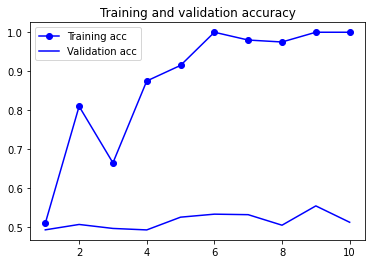

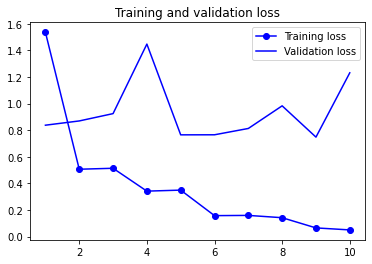

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we picked, and we picked them at random. 

We can also try to train the same model `without loading the pre-trained GloVe word embeddings` (and thus `without freezing the embedding layer`). In that case, we would be learning a `task-specific embedding` of our input tokens, which is generally `more powerful than pre-trained word embeddings` when lots of data is available. 

In our case, we have little data -- only 200 training samples. But let's try it anyway:

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()

"""we don't set weight of the embedding layers this time, nor make it untrainable."""
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 0s 46ms/step - loss: 0.6918 - acc: 0.5400 - val_loss: 0.6928 - val_acc: 0.5140
Epoch 2/10
7/7 [==============================] - 0s 33ms/step - loss: 0.4832 - acc: 0.9900 - val_loss: 0.6962 - 

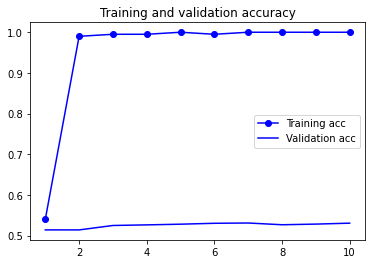

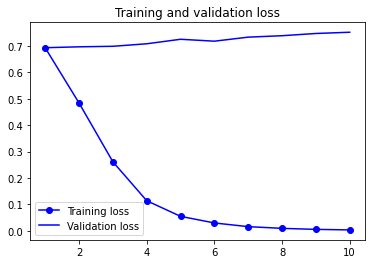

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Validation accuracy stalls in the low 50s. So with little data (200 samples), `pre-trained word embeddings` outperforms `learned embeddings`. 

If you increase the number of training samples, you will see `learned embeddings` outperforms `pre-trained word embeddings`.

## Evaluate the model on the test data

In [16]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [17]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 653us/step - loss: 1.2535 - acc: 0.5050


[1.2534862756729126, 0.5049600005149841]